In [1]:
from src.containers.evaluation_container import EvaluationContainer
from src.services.config.config_interface import DirConfig
from src.utils import tqdm_joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import japanize_matplotlib

plt.style.use("ggplot")
dir_config = DirConfig(env='local', exp='eval_previous', debug=False)

coupon_type_to_color = {
    'control': '#E24A33',
    '5% back': '#348ABD',
    '5% off':'#988ED5',
    '300yen off':'#777777',  
    '10% off': '#FBC15E', 
    '10% back': '#8EBA42', 
    '15% off': '#FFB5B8'
}

In [3]:
def evaluate(exp):
    container = EvaluationContainer(exp, debug=False)
    name = container.config.base_config.name
    container.initialize()
    base_config = container.config.base_config
    config = container.config
    postprocess_config = config.postprocess_config

    n_sample = min(container.test_df.shape[0], postprocess_config.n_sample)
    random_checked = set()
    results =[]
    # self.assignments.append([name, seed, budget_constraint, assignment])
    for seed, budget_constraint, assginment in container.assignments:
        # test_dfからランダムにn_sample個のidxを取得
        sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
        # sample_idxのデータを取得しsample_dfに格納
        sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
        # target列にGMVを代入
        sample_df['target'] = sample_df[base_config.target_name]
        # sample_dfのなかで各config.treatment_nameの数をカウント
        n_treatment = sample_df[base_config.treatment_name].value_counts().to_dict()
        n_treatment_all = sum(n_treatment.values())
        # cost列にvariant_no_to_costの値を代入
        sample_df['cost'] = sample_df[base_config.treatment_name].map(postprocess_config.variant_no_to_cost)
            
        # model
        gmv = 0
        cost = 0
        for t in range(1, 7):
            gmv += sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
            gmv -= sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            cost += sample_df['cost'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()
            # cost -= sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
        results.append([exp, name, seed, cost, gmv, rate, budget_constraint])
    return results

def random_evaluate(exp):
    container = EvaluationContainer(exp, debug=False)
    name = container.config.base_config.name
    container.initialize()
    base_config = container.config.base_config
    config = container.config
    postprocess_config = config.postprocess_config

    n_sample = min(container.test_df.shape[0], postprocess_config.n_sample)
    random_checked = set()
    results =[]
    # self.assignments.append([name, seed, budget_constraint, assignment])
    for seed, budget_constraint, assginment in container.assignments:
        # test_dfからランダムにn_sample個のidxを取得
        sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
        # sample_idxのデータを取得しsample_dfに格納
        sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
        # target列にGMVを代入
        sample_df['target'] = sample_df[base_config.target_name]
        # sample_dfのなかで各config.treatment_nameの数をカウント
        n_treatment = sample_df[base_config.treatment_name].value_counts().to_dict()
        n_treatment_all = sum(n_treatment.values())
        # cost列にvariant_no_to_costの値を代入
        sample_df['cost'] = sample_df[base_config.treatment_name].map(postprocess_config.variant_no_to_cost)
        # # random
        if (seed,budget_constraint) not in random_checked:
            # cost列の累積和がbudget_constraintを超えるidxを取得 frac=1は100%とってきてシャッフル
            # assign_indexはあとで0にするindex
            assgin_index = (sample_df.sample(frac=1)['cost'].cumsum() > budget_constraint).sort_index()
            # assginment列に0~6の乱数を代入 -> 1~6では？ 
            sample_df['assginment'] = np.random.randint(0, 7, len(sample_df))
            # assgin_indexのidxに0を上書き
            sample_df.loc[assgin_index, 'assginment'] = 0
            # upliftgmv
            random_gmv = 0
            cost = 0
            for t in range(1, 7):
                random_gmv += sample_df['target'][(sample_df['assginment']==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
                random_gmv -= sample_df['target'][(sample_df['assginment']==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
                cost += sample_df['cost'][(sample_df['assginment']==t)& (sample_df[base_config.treatment_name]==t)].sum()
                #cost -= sample_df['cost'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            # 一致しているものの割合 -> つかってない
            # 実際のconfig.treatment_nameとassginmentが一致していないものを集計
            random_rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
            results.append(['random', seed, cost, random_gmv, random_rate])   
            random_checked.add((seed,budget_constraint))

    return results

def get_random_result(exp, n_trial):
    num_cores = multiprocessing.cpu_count()
    with tqdm_joblib(n_trial):
        results = Parallel(n_jobs=num_cores)([delayed(random_evaluate)(exp) for _ in range(n_trial)])

    # flatten
    results = [result for result_list in results for result in result_list]

    result_df = pd.DataFrame(results, columns=['name', 'seed', 'cost', 'GMV', 'assign_rate'])
    result_df['cost'] = result_df['cost'].astype(int)
    result_df = result_df.groupby('cost')['GMV'].mean().reset_index()
    result_df['name'] = 'random'

    return result_df

In [ ]:
previous_exp = 'optimize208_v2'
proposed_exp = 'optimize205_v2'
exps = [previous_exp, proposed_exp]
results = [evaluate(exp) for exp in exps]
results = [item for sublist in results for item in sublist]
result_df = pd.DataFrame(results, columns=['exp', 'name', 'seed', 'cost', 'GMV', 'assign_rate', 'budget_constraint'])
result_df['cost'] = result_df['cost'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)

random_result_df = get_random_result(proposed_exp, 30)

In [9]:
result_df = result_df.sort_values(['exp', 'cost'], ascending=True).reset_index(drop=True)

Text(0.5, 1.0, '先行研究と提案手法の比較')

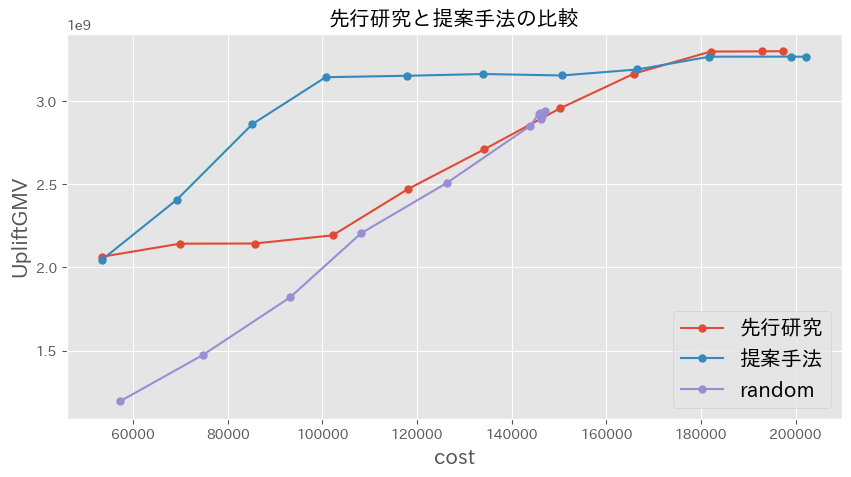

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

previous_result = result_df[result_df['exp']==previous_exp].reset_index(drop=True)
ax.plot(
    previous_result['cost'],
    previous_result['GMV'],
    label='先行研究',
    marker='o',
    markersize=5,
)

proposed_result = result_df[result_df['exp']==proposed_exp].reset_index(drop=True)
ax.plot(
    proposed_result['cost'],
    proposed_result['GMV'],
    label='提案手法',
    marker='o',
    markersize=5,
)

ax.plot(
    random_result_df['cost'],
    random_result_df['GMV'],
    label='random',
    marker='o',
    markersize=5,
)

ax.legend(fontsize=15)
ax.set_xlabel('cost', fontsize=15)
ax.set_ylabel('UpliftGMV', fontsize=15)
ax.set_title('先行研究と提案手法の比較', fontsize=15)